# Telecom RAN Data Generation: Basic Example

This notebook demonstrates how to generate synthetic timeseries data for a telecom Radio Access Network (RAN) using Rockfish's Entity Data Generator.

**What this notebook shows:**
- Creating a Rockfish `DataSchema` with three entities (`transport_link`, `core_node`, `cell_site`)
- Generating baseline data with realistic temporal patterns
- Visualizing timeseries metrics with seasonality and anomalies
- Validating entity relationships and referential integrity

**Generated data:**
- 6 transport links × 193 timestamps (2 days @ 15min) = 1,158 rows
- 16 core nodes × 193 timestamps = 3,088 rows
- 100 cell sites × 193 timestamps = 19,300 rows
- **Total: ~24,000 rows**

## Setup and Imports

In [1]:
import rockfish as rf
import rockfish.actions as ra
from dotenv import load_dotenv

from utils import (
    create_telecom_ran_schema,
    plot_metric_over_time,
    plot_metrics_over_time,
)

In [2]:
# Connect to the Rockfish platform using your API Key
load_dotenv()
conn = rf.Connection.from_env()

## Create Schema

We'll generate data for a telecom RAN network `DataSchema` with three entities:
- **transport_link**: Network infrastructure devices
- **core_node**: Core network elements like MME, AMF, SMF, UPF
- **cell_site**: Radio access points serving end users

For an in-depth explanation of the Rockfish Entity Data Generator and the example schema used in this tutorial, please refer to [rf_telecom_ran_tutorial.md](rf_telecom_ran_tutorial.md).

In [3]:
# Create the schema instance
telecom_ran_schema = create_telecom_ran_schema()

## Run Data Generation

We'll use a **Rockfish Workflow** to run a data generation job on the Rockfish platform.

<div class="alert alert-block alert-info">
<b>ℹ️ Info: Rockfish Workflows and Actions</b>

A Rockfish Workflow is a job that you want to run on the Rockfish platform. You can think of a workflow as a graph of operations that take you from an input (e.g., data schema) to an output (e.g., datasets). Each operation in this graph is a Rockfish Action.

The Rockfish SDK has a variety of actions designed to make operations like data processing, model training/inference, and data generation easier. Each Rockfish action has a config, which can be used to control action behavior.
</div>

In [4]:
config = ra.GenerateFromDataSchema.Config(
    schema=telecom_ran_schema,
    upload_datasets=True,
)
generate = ra.GenerateFromDataSchema(config)

In [5]:
builder = rf.WorkflowBuilder()
builder.add(generate)
workflow = await builder.start(conn)
print(f"Workflow ID: {workflow.id()}")

Workflow ID: 1E2TCNEgdg2ZrhSLY5Joh2


In [6]:
async for log in workflow.logs(level=rf.events.LogLevel.DEBUG):
    print(log)

2025-11-21T15:29:59.608263Z generate-from-data-schema: INFO Generating 3 entities: transport_link, core_node, cell_site
2025-11-21T15:29:59.615011Z generate-from-data-schema: INFO Starting data generation...
2025-11-21T15:30:00.440674Z generate-from-data-schema: INFO Generated 3 entity tables
2025-11-21T15:30:00.451943Z generate-from-data-schema: INFO Creating dataset for entity 'transport_link': 1158 rows
2025-11-21T15:30:00.673783Z generate-from-data-schema: INFO Uploaded dataset 'transport_link' (XcKUuTwZZ2tGYuYpTCCRe): 1158 rows
2025-11-21T15:30:00.690527Z generate-from-data-schema: INFO Creating dataset for entity 'core_node': 3088 rows
2025-11-21T15:30:00.870517Z generate-from-data-schema: INFO Uploaded dataset 'core_node' (4gj7EOSvqmdNWPd5EIVHkN): 3088 rows
2025-11-21T15:30:00.885963Z generate-from-data-schema: INFO Creating dataset for entity 'cell_site': 19300 rows
2025-11-21T15:30:01.083443Z generate-from-data-schema: INFO Uploaded dataset 'cell_site' (5s3Efhb4Dqdt7SwlUf6LwA)

## Retrieve Generated Datasets

We'll retrieve datasets for `transport_link`, `core_node`, and `cell_site` entities.

In [7]:
datasets = await workflow.datasets().collect()
print(f"Generated {len(datasets)} datasets")

transport_link_dataset = None
core_node_dataset = None
cell_site_dataset = None
for remote_ds in datasets:
    ds = await remote_ds.to_local(conn)
    if ds.name() == "transport_link":
        transport_link_dataset = ds
    elif ds.name() == "core_node":
        core_node_dataset = ds
    elif ds.name() == "cell_site":
        cell_site_dataset = ds

Generated 3 datasets


## Explore Transport Link Data

We'll visualize the following timeseries metrics: bandwidth utilization, packet loss, latency, and jitter.

In [8]:
transport_link_df = transport_link_dataset.to_pandas()
print(f"Transport Link dataset: {transport_link_dataset.table.num_rows} rows")
transport_link_df.head()

Transport Link dataset: 1158 rows


,Device_ID,Interface_ID,Bandwidth_Utilization_Out,Packet_Loss_Percent,Latency_ms,Jitter_ms,Timestamp
0,RTR_004,eth1,57.627208,0.387565,15.986711,1.958601,2025-01-01T00:00:00+00:00
1,RTR_004,eth1,56.786161,0.443919,15.780268,1.888845,2025-01-01T00:15:00+00:00
2,RTR_004,eth1,55.739454,0.516126,15.453610,1.849660,2025-01-01T00:30:00+00:00
3,RTR_004,eth1,51.060260,0.471744,15.776317,1.964455,2025-01-01T00:45:00+00:00
4,RTR_004,eth1,51.271135,0.398359,15.292285,2.151212,2025-01-01T01:00:00+00:00


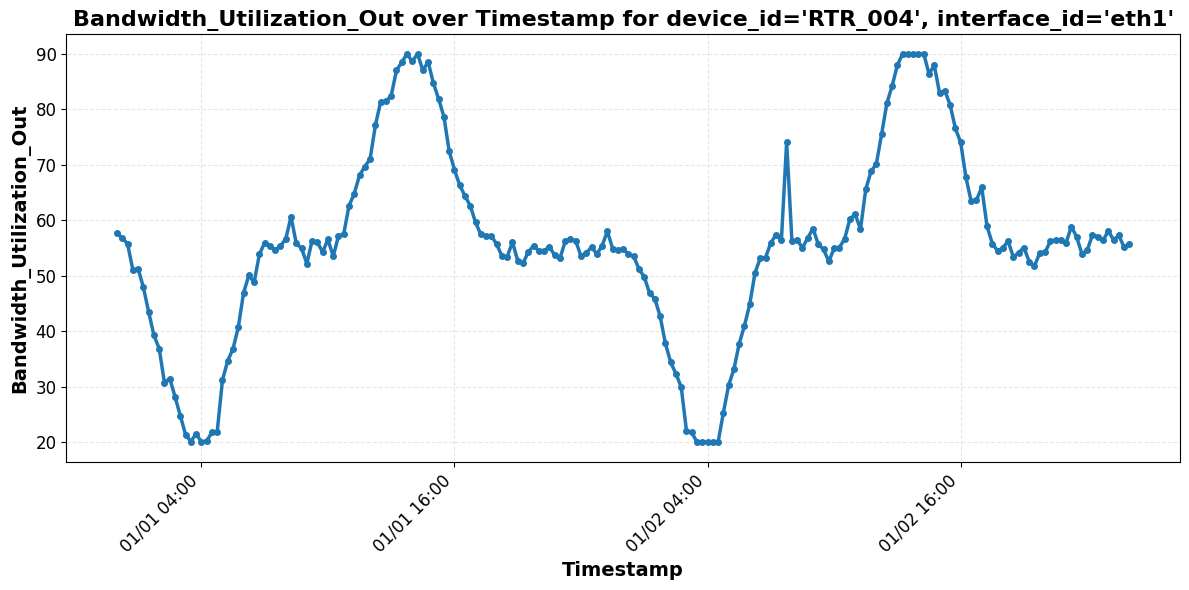

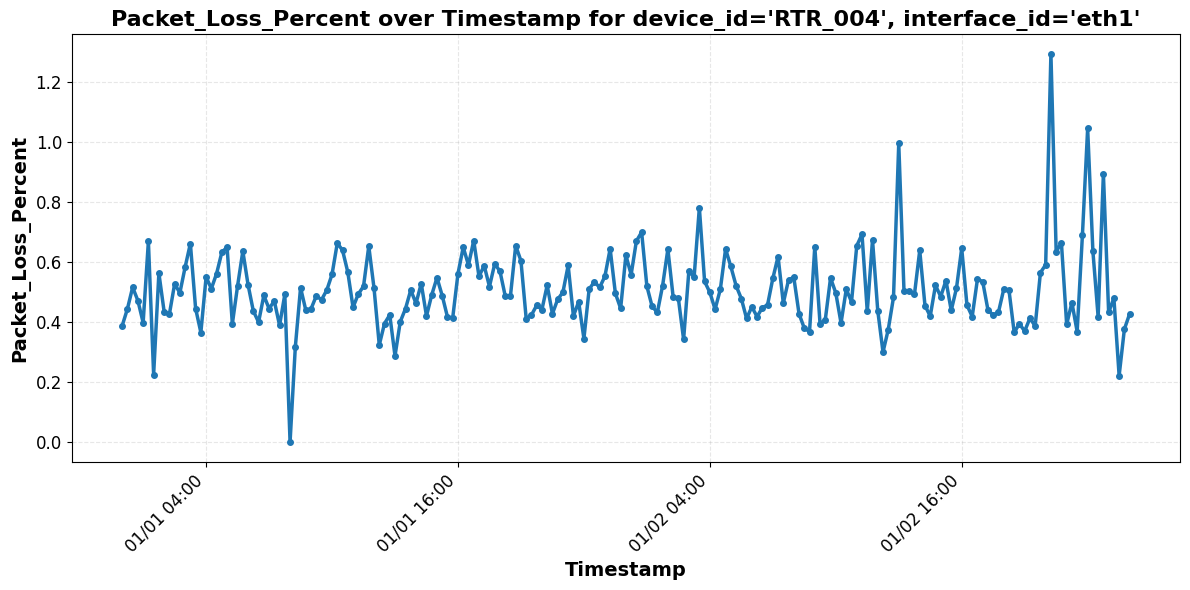

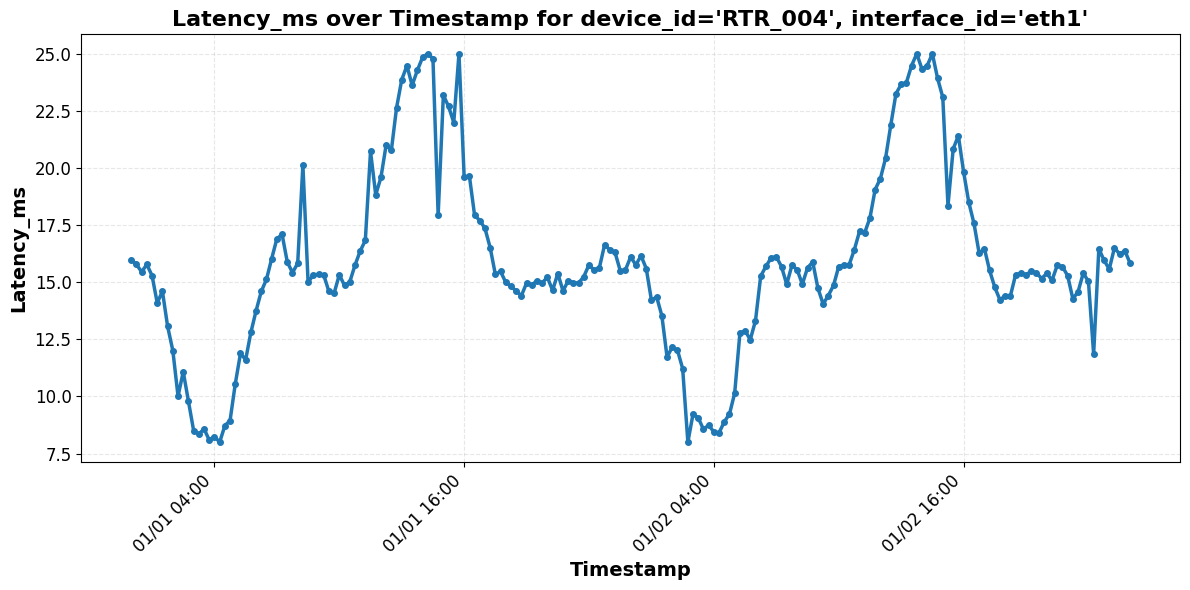

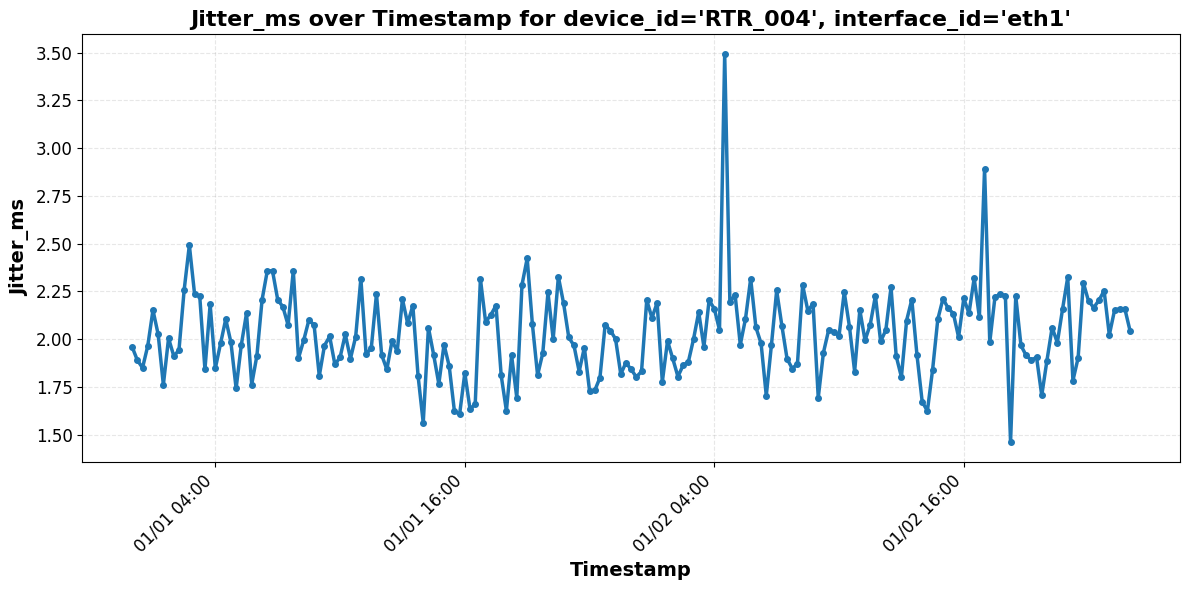

In [9]:
device_id = "RTR_004"
interface_id = "eth1"
ts = "Timestamp"
df = transport_link_df[
    (transport_link_df["Device_ID"] == device_id)
    & (transport_link_df["Interface_ID"] == interface_id)
]
for col in [
    "Bandwidth_Utilization_Out",
    "Packet_Loss_Percent",
    "Latency_ms",
    "Jitter_ms",
]:
    plot_metric_over_time(
        df,
        metric_col=col,
        timestamp_col=ts,
        title=f"{col} over {ts} for {device_id=}, {interface_id=}",
    )

## Explore Core Node Data

We'll visualize the following timeseries metrics: attached UEs, active PDU sessions, and CPU load.

In [10]:
core_node_df = core_node_dataset.to_pandas()
print(f"Core Node dataset: {core_node_dataset.table.num_rows} rows")
core_node_df.head()

Core Node dataset: 3088 rows


,Core_Node_ID,MM_AttachedUEs,SM_ActivePDUSessions,CPU_Load,Timestamp
0,MME_001,5310,3068,54.467745,2025-01-01T00:00:00+00:00
1,MME_001,5252,3145,59.791042,2025-01-01T00:15:00+00:00
2,MME_001,5248,3153,58.520525,2025-01-01T00:30:00+00:00
3,MME_001,4960,3037,57.107058,2025-01-01T00:45:00+00:00
4,MME_001,5080,2863,53.845959,2025-01-01T01:00:00+00:00


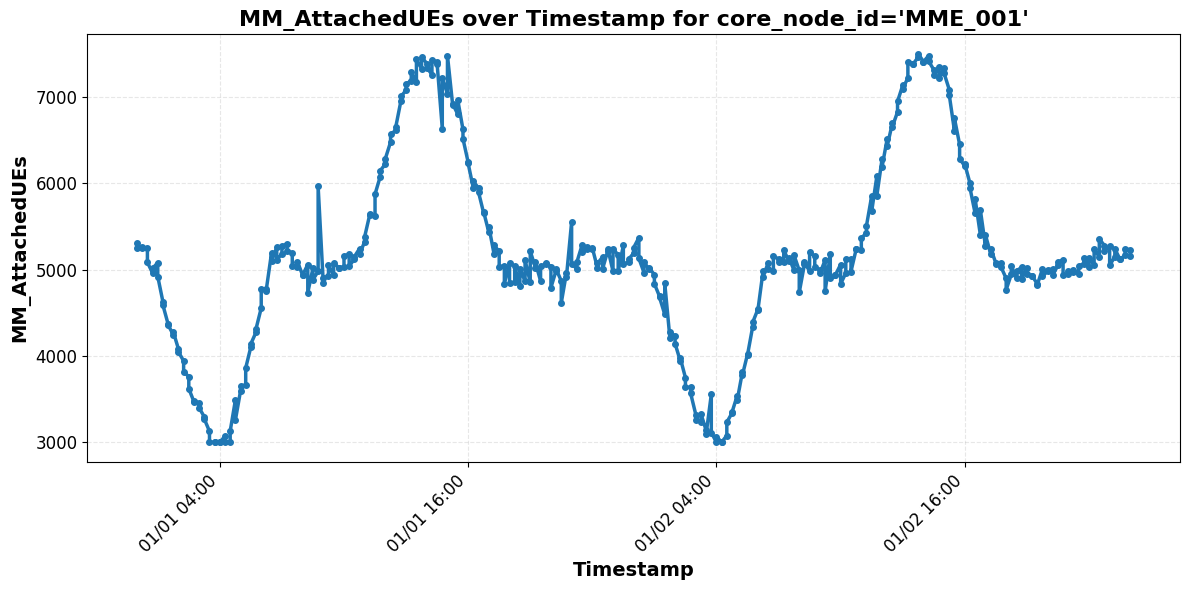

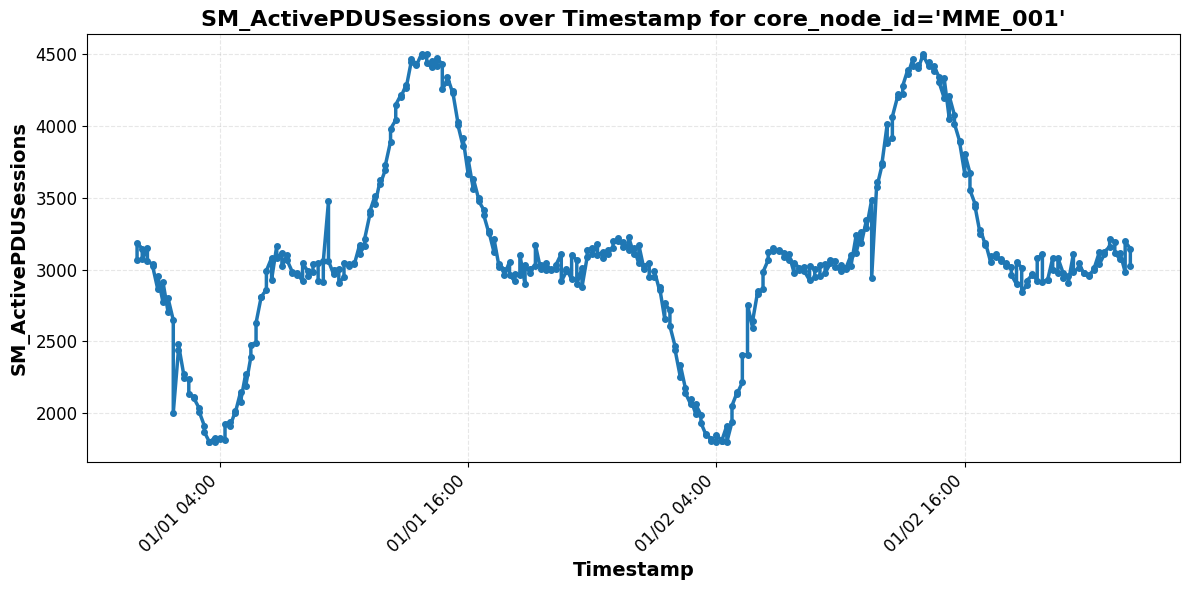

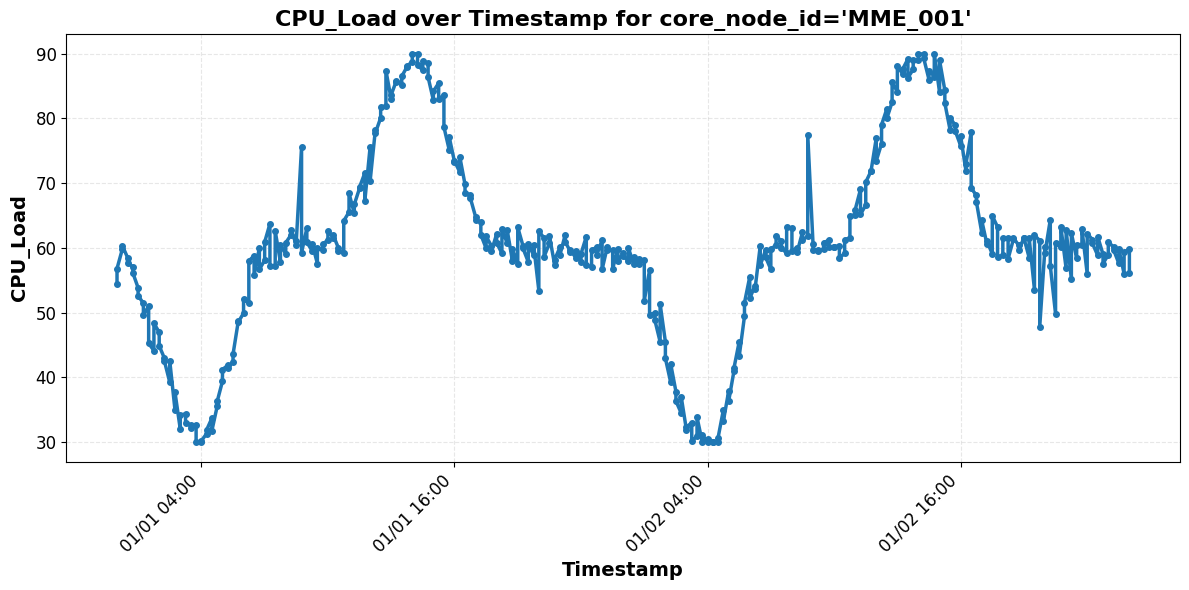

In [11]:
core_node_id = "MME_001"
ts = "Timestamp"
df = core_node_df[core_node_df["Core_Node_ID"] == core_node_id]
for col in ["MM_AttachedUEs", "SM_ActivePDUSessions", "CPU_Load"]:
    plot_metric_over_time(
        df,
        metric_col=col,
        timestamp_col=ts,
        title=f"{col} over {ts} for {core_node_id=}",
    )

## Explore Cell Site Data

We'll visualize the following timeseries metrics: RRC connection metrics, bearer establishment, resource utilization, and availability.

In [12]:
cell_site_df = cell_site_dataset.to_pandas()
print(f"Cell Site dataset: {cell_site_dataset.table.num_rows} rows")
cell_site_df.head()

Cell Site dataset: 19300 rows


,Cell_ID,Base_Station_ID,Location_Lat,Location_Lon,Transport_Device_ID,Transport_Interface_ID,RRC_ConnEstabFail,RRC_ConnEstabSucc,RRC_ConnEstabAtt,ERAB_EstabInitSuccNbr_QCI,DL_PRB_Utilization,Cell_Availability,Timestamp
0,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,9,92,102,94.291707,51.213983,99.493276,2025-01-01T00:00:00+00:00
1,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,9,96,106,93.241803,52.994845,99.484967,2025-01-01T00:15:00+00:00
2,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,8,91,100,91.981074,51.790901,99.495991,2025-01-01T00:30:00+00:00
3,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,9,91,100,90.071331,51.306298,99.531170,2025-01-01T00:45:00+00:00
4,CELL_0,eNB_001,40.346287,-79.219057,RTR_002,eth3,7,92,100,86.199011,49.888713,99.540730,2025-01-01T01:00:00+00:00


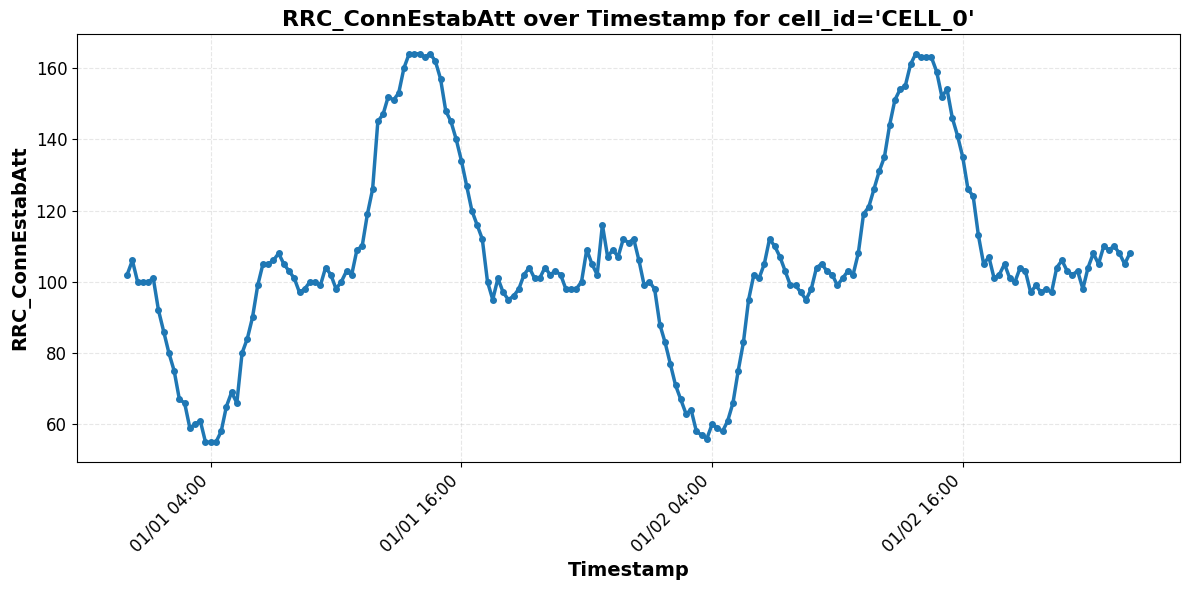

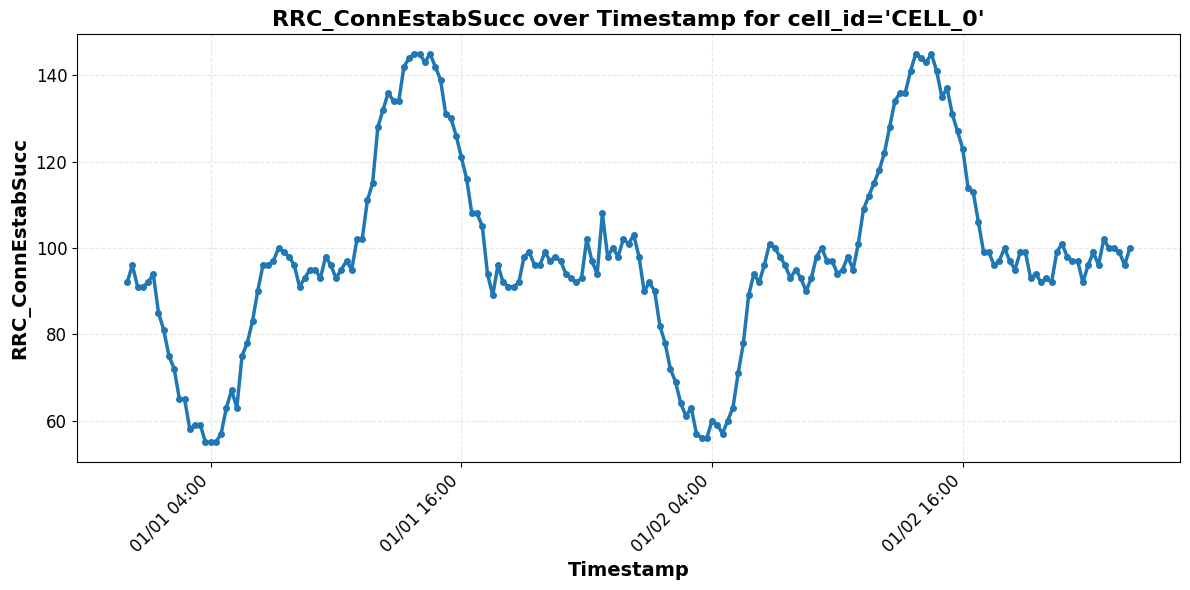

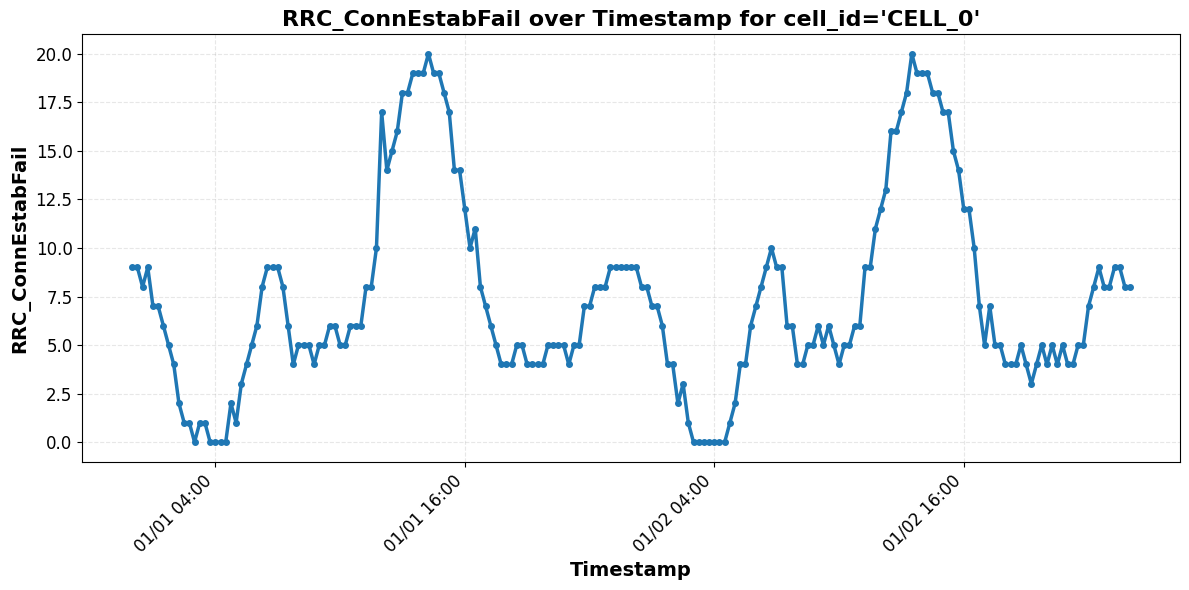

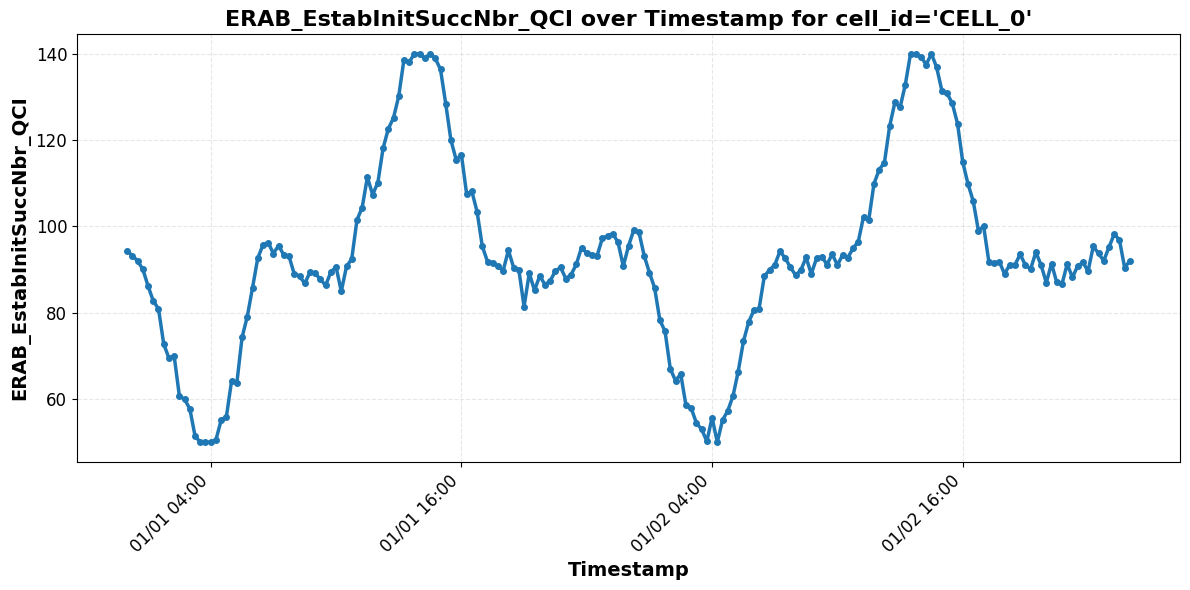

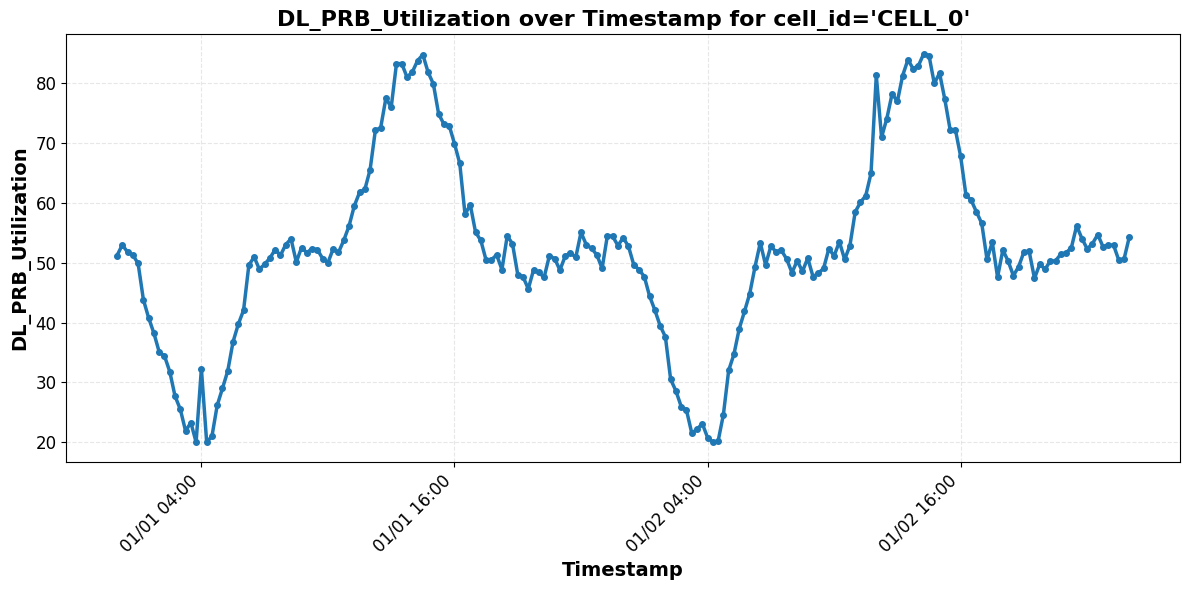

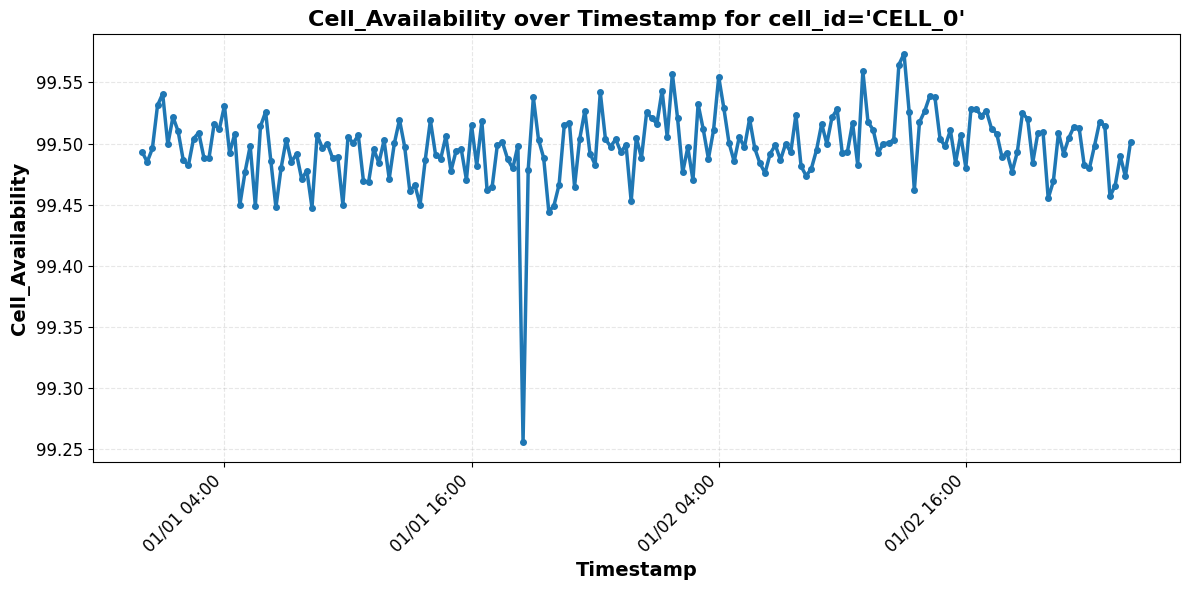

In [13]:
cell_id = "CELL_0"
ts = "Timestamp"
df = cell_site_df[cell_site_df["Cell_ID"] == cell_id]
for col in [
    "RRC_ConnEstabAtt",
    "RRC_ConnEstabSucc",
    "RRC_ConnEstabFail",
    "ERAB_EstabInitSuccNbr_QCI",
    "DL_PRB_Utilization",
    "Cell_Availability",
]:
    plot_metric_over_time(
        df, metric_col=col, timestamp_col=ts, title=f"{col} over {ts} for {cell_id=}"
    )

### Derived Column Example: RRC_ConnEstabAtt

This plot shows how `RRC_ConnEstabAtt` (total attempts) is derived as the sum of `RRC_ConnEstabSucc` (successes) and `RRC_ConnEstabFail` (failures).

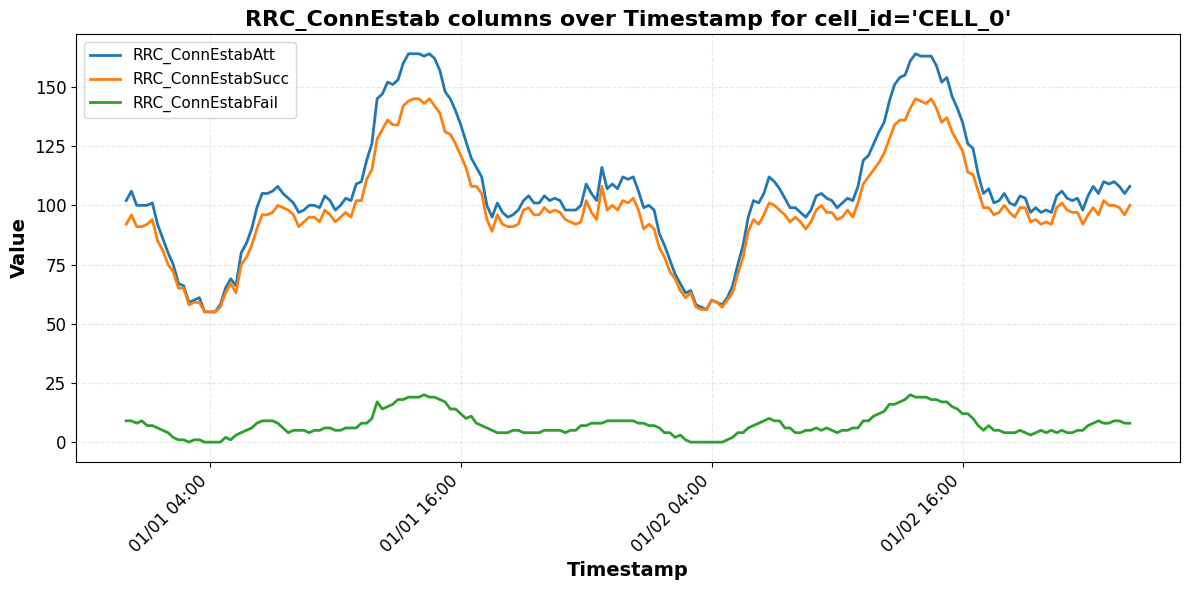

In [14]:
cell_id = "CELL_0"
ts = "Timestamp"
df = cell_site_df[cell_site_df["Cell_ID"] == cell_id]
metric_cols = ["RRC_ConnEstabAtt", "RRC_ConnEstabSucc", "RRC_ConnEstabFail"]
plot_metrics_over_time(
    df,
    metric_cols,
    timestamp_col=ts,
    title=f"RRC_ConnEstab columns over {ts} for {cell_id=}",
);

## Validate Entity Relationships

We'll verify that all `cell_site` foreign keys reference valid `transport_link` entities (composite foreign key: Device_ID + Interface_ID).

In [15]:
# Validate composite foreign key integrity
# Create set of valid (device_id, interface_id) pairs from transport_link
valid_pairs = set(
    zip(transport_link_df["Device_ID"], transport_link_df["Interface_ID"])
)
print(f"Valid transport_link pairs: {len(valid_pairs)}")

# Create set of (transport_device_id, transport_interface_id) pairs from cell_site
cell_site_pairs = set(
    zip(cell_site_df["Transport_Device_ID"], cell_site_df["Transport_Interface_ID"])
)
print(f"Cell site pairs: {len(cell_site_pairs)}")

# Check all cell site pairs are valid
invalid_pairs = cell_site_pairs - valid_pairs
print(f"All cell_site pairs are valid: {len(invalid_pairs) == 0}")
if invalid_pairs:
    print(f"Invalid pairs found: {invalid_pairs}")

Valid transport_link pairs: 6
Cell site pairs: 6
All cell_site pairs are valid: True


## Save Data to CSV

In [16]:
# Save all datasets to file
transport_link_df.to_csv("transport_link_data.csv", index=False)
core_node_df.to_csv("core_node_data.csv", index=False)
cell_site_df.to_csv("cell_site_data.csv", index=False)